## Importando bibliotecas e base

In [1]:
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from util import *
import joblib

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

C:\Users\Jean\Documents\projetos\telco_churn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../data/processed/df.parquet")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Houldout Out-Of-Sample

In [3]:
# Separando as variáveis de entrada (features) e de saída (target)
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [4]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((4930, 19), (2113, 19))

## Dataprep e Feature Selection

In [5]:
cat_attributes = X_train.select_dtypes(include='object')
num_attributes = X_train.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])


X_train_processed = pd.DataFrame(preprocesssor.fit_transform(X_train, y_train),columns=X_train.columns)
X_test_processed = pd.DataFrame(preprocesssor.transform(X_test),columns=X_test.columns)
#X_prod_processed = pd.DataFrame(preprocessor.transform(df_test),columns=df_test.columns)

In [6]:
# Salva o pipeline na pasta models
joblib.dump(preprocesssor, '../models/preprocesssor.joblib')

['../models/preprocesssor.joblib']

## Feature Selection

In [7]:
X_train_transformed = X_train_processed

In [8]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

Número de features selecionadas:  7


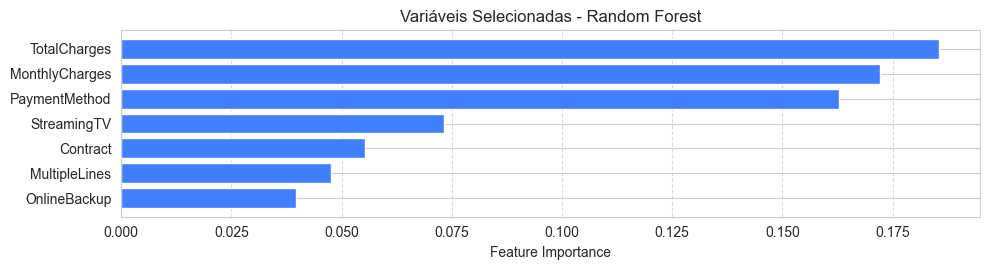

In [9]:
#Obtendo o feature importance
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=False)

#Estabelecendo um ponto de corte
cutoff_maximp = 0.2

cutoff = cutoff_maximp * feature_importances.max()

# Selecionando vars acima do ponto de corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ', len(selected_features))

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Salva as features selecionadas na pasta models
joblib.dump(selected_features, '../models/selected_features.joblib')

['../models/selected_features.joblib']

In [11]:
selected_features

['MultipleLines',
 'OnlineBackup',
 'StreamingTV',
 'Contract',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

## Testar algoritmos

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
algoritmos = [
    DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=5, min_samples_leaf=2),
    RandomForestClassifier(random_state=0, max_depth=5, min_samples_leaf=2),
    GradientBoostingClassifier(random_state=0, max_depth=5, min_samples_leaf=2),
    HistGradientBoostingClassifier(random_state=0, max_depth=5, min_samples_leaf=2),
    LGBMClassifier(random_state=0, max_depth=5, min_child_samples=2, n_jobs=-1)  # LightGBM
]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed[selected_features],y_train)

    # Avaliar modelo
    metricas = calculate_metrics_models_classifier(nome_algoritmo,algoritmo, X_train_processed[selected_features], y_train, X_test_processed[selected_features], y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.802231,0.621029,0.633977,0.848157,0.696313,0.536993
1,DecisionTreeClassifier,Teste,0.787033,0.605442,0.620209,0.826660,0.653319,0.512112


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.806491,0.686339,0.484942,0.856906,0.713812,0.554569
1,RandomForestClassifier,Teste,0.799811,0.682809,0.491289,0.852467,0.704933,0.560206


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.870385,0.807692,0.664865,0.929140,0.858280,0.693273
1,GradientBoostingClassifier,Teste,0.793658,0.650655,0.519164,0.844184,0.688368,0.541984


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,HistGradientBoostingClassifier,Treino,0.847465,0.749770,0.629344,0.923311,0.846622,0.700984
1,HistGradientBoostingClassifier,Teste,0.796498,0.655172,0.529617,0.847476,0.694952,0.537841


[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.850101,0.752727,0.639382,0.922707,0.845413,0.693890
1,LGBMClassifier,Teste,0.798864,0.656184,0.545296,0.847334,0.694668,0.544084


## Tunagem de hiperparâmetros

In [13]:
import optuna

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [15]:


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
from sklearn.model_selection import StratifiedKFold


def objective(trial):
    # Espaço de busca de hiperparâmetros
    param = {
    "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    "max_depth": trial.suggest_int("max_depth", 3, 30),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
    "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    "class_weight": trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"])
    }

    # Validação cruzada
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    avg_roc = 0

    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        Xtr, Xvl = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
        ytr, yvl = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(**param, random_state=0, n_jobs=-1)
        model.fit(Xtr, ytr)
        preds = model.predict_proba(Xvl)[:, 1]
        avg_roc += roc_auc_score(yvl, preds)

    return avg_roc / 5

study = optuna.create_study(direction="maximize",study_name="modelo11", storage="sqlite:///modelo.db")
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    study = optuna.load_study(study_name="modelo11", storage="sqlite:///modelo.db")
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#n_jobs=-1

[I 2025-05-19 19:08:05,651] A new study created in RDB with name: modelo11
[I 2025-05-19 19:08:08,524] Trial 0 finished with value: 0.842382350910549 and parameters: {'n_estimators': 445, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.842382350910549.
[I 2025-05-19 19:08:12,991] Trial 1 finished with value: 0.8423738535155316 and parameters: {'n_estimators': 485, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.842382350910549.
[I 2025-05-19 19:08:14,608] Trial 2 finished with value: 0.7933502573117428 and parameters: {'n_estimators': 125, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.842382350910549.
[I 2025-05-1

EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.8429463655048248
  Params: 
    n_estimators: 496
    max_depth: 9
    min_samples_split: 7
    min_samples_leaf: 19
    max_features: sqrt
    bootstrap: True
    class_weight: balanced_subsample


In [17]:
from sklearn.calibration import CalibratedClassifierCV

# Modelo base
modelo_base = RandomForestClassifier(**study.best_params, random_state=0)

# Envolvendo com CalibratedClassifierCV
algoritmo = CalibratedClassifierCV(estimator=modelo_base, method='sigmoid', cv=5)

# Nome do algoritmo
nome_algoritmo = f"Calibrated({type(modelo_base).__name__})"

# Treino do modelo calibrado
algoritmo.fit(X_train_processed, y_train)

# Avaliar modelo
metricas = calculate_metrics_models_classifier(nome_algoritmo, algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,Calibrated(RandomForestClassifier),Treino,0.819473,0.686981,0.574517,0.874380,0.748759,0.589748
1,Calibrated(RandomForestClassifier),Teste,0.806436,0.673684,0.557491,0.861061,0.722121,0.580349


<Figure size 800x600 with 0 Axes>

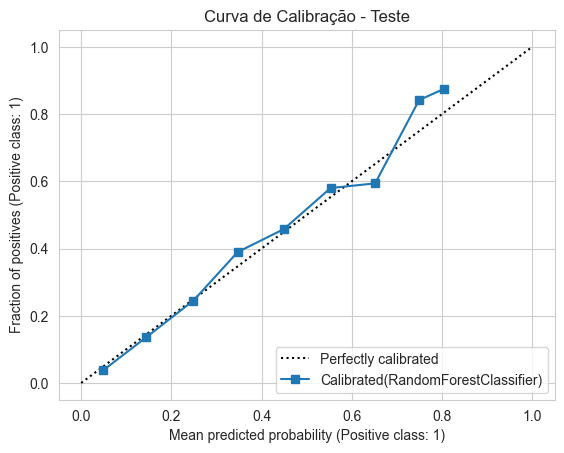

In [18]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# Plotar curva de calibração no conjunto de teste
plt.figure(figsize=(8, 6))
CalibrationDisplay.from_estimator(algoritmo, X_test_processed, y_test, n_bins=10, name=nome_algoritmo)
plt.title("Curva de Calibração - Teste")
plt.grid(True)
plt.show()


In [19]:
# Salva as features selecionadas na pasta models
joblib.dump(algoritmo, '../models/algoritmo.joblib')

['../models/algoritmo.joblib']